# Install dependencies  
This cell installs all the necessary Python packages to run the notebook. Run only once or when setting up a new environment.

In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow keras keras-tuner kagglehub

# Load and prepare dataset  
Download the S&P 500 dataset, parse dates, and set the datetime index for time series operations.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
import kagglehub

path = kagglehub.dataset_download("camnugent/sandp500")
df = pd.read_csv(os.path.join(path, "all_stocks_5yr.csv"))
df['DateIndex'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['DateIndex'])
df.set_index('DateIndex', inplace=True)
df.drop(columns=['date'], inplace=True)

# Clean and prepare time series data  
Interpolate missing OHLCV values and fallback to 'close'. Select one stock (e.g. STX).

In [3]:
for col in ['open', 'high', 'low', 'volume']:
    df[col] = df.groupby('Name')[col].transform(lambda x: x.interpolate(method='time'))
for col in ['open', 'high', 'low']:
    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), 'close']

stock_name = "STX"
ts_data = df[df['Name'] == stock_name][['open', 'high', 'low', 'close', 'volume']].sort_index()
ts_data['log_return'] = np.log(ts_data['close'] / ts_data['close'].shift(1))
ts_data = ts_data.dropna()

# Split data into train, validation, and test sets  
Use the last year as test, the 6 months before as validation, and the rest for training.


In [4]:
test_start = ts_data.index.max() - pd.DateOffset(years=1)
val_start = test_start - pd.DateOffset(months=6)

train_data = ts_data[ts_data.index < val_start]
val_data = ts_data[(ts_data.index >= val_start) & (ts_data.index < test_start)]
test_data = ts_data[ts_data.index >= test_start]

print(f"Train: {train_data.shape}, Validation: {val_data.shape}, Test: {test_data.shape}")


Train: (879, 6), Validation: (126, 6), Test: (253, 6)


# Normalize and generate input sequences  
Scale data with MinMaxScaler and convert into sequences for supervised learning.


In [5]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length, 3]  # 'close'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

sequence_length = 30
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(val_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

X_train = X_train.reshape((-1, sequence_length, X_train.shape[2]))
X_val = X_val.reshape((-1, sequence_length, X_val.shape[2]))
X_test = X_test.reshape((-1, sequence_length, X_test.shape[2]))


# Build LSTM model with tunable hyperparameters  
Define the model with Keras Tuner parameters for number of units, dropout, and optimizer.


In [6]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int("units1", 32, 128, step=32), return_sequences=True,
                   input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dropout(hp.Float("dropout1", 0.1, 0.5, step=0.1)))
    model.add(LSTM(hp.Int("units2", 32, 128, step=32)))
    model.add(Dropout(hp.Float("dropout2", 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "rmsprop"]),
                  loss="mse", metrics=["mae"])
    return model

# Hyperparameter tuning with Keras Tuner  
Use RandomSearch to find the best configuration minimizing validation loss.

In [7]:
import shutil
shutil.rmtree("tuner_logs/lstm_stock_optimization", ignore_errors=True)

tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="lstm_stock_optimization"
)

early_stop = EarlyStopping(monitor="val_loss", patience=3)
tuner.search(X_train, y_train, validation_data=(X_val, y_val),
             epochs=20, batch_size=64, callbacks=[early_stop])

best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 07s]
val_loss: 0.002095346339046955

Best val_loss So Far: 0.0017964517464861274
Total elapsed time: 00h 00m 59s


c:\Users\Utente\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Plot validation loss against hyperparameter values  
Visualize how the search space affects model performance.

Results summary
Results in tuner_logs\lstm_stock_optimization
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
units1: 128
dropout1: 0.30000000000000004
units2: 128
dropout2: 0.5
optimizer: adam
Score: 0.0017964517464861274

Trial 02 summary
Hyperparameters:
units1: 32
dropout1: 0.30000000000000004
units2: 64
dropout2: 0.30000000000000004
optimizer: adam
Score: 0.0020165040623396635

Trial 05 summary
Hyperparameters:
units1: 32
dropout1: 0.5
units2: 64
dropout2: 0.4
optimizer: rmsprop
Score: 0.0020336294546723366

Trial 09 summary
Hyperparameters:
units1: 64
dropout1: 0.30000000000000004
units2: 64
dropout2: 0.1
optimizer: adam
Score: 0.002095346339046955

Trial 04 summary
Hyperparameters:
units1: 64
dropout1: 0.5
units2: 128
dropout2: 0.30000000000000004
optimizer: adam
Score: 0.002144819125533104

Trial 01 summary
Hyperparameters:
units1: 128
dropout1: 0.30000000000000004
units2: 128
dropout2: 0.30000000000000004
optimizer: rmsprop

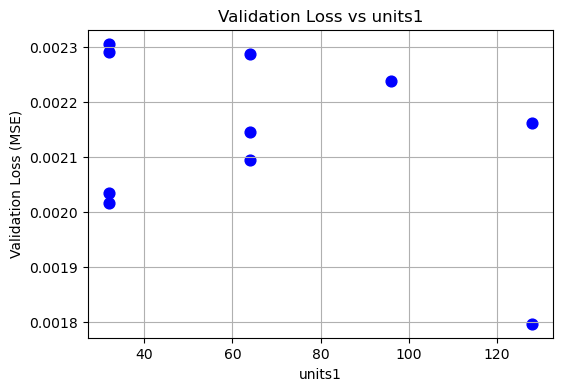

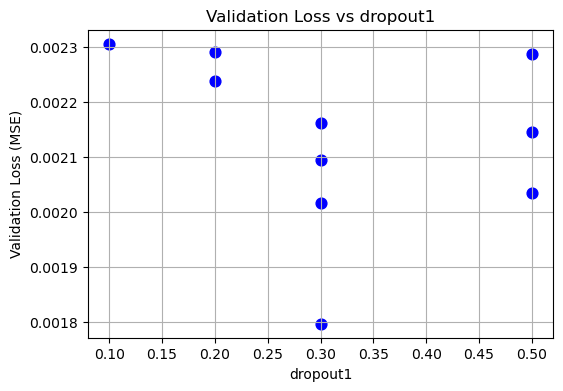

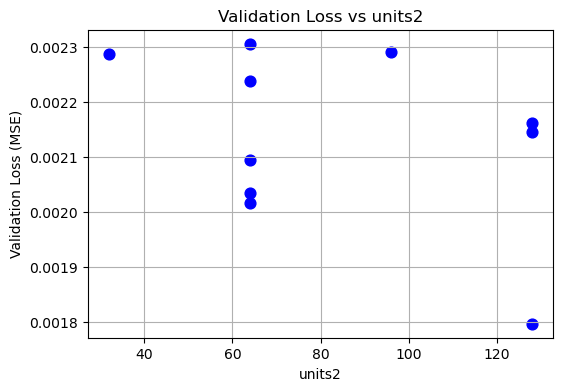

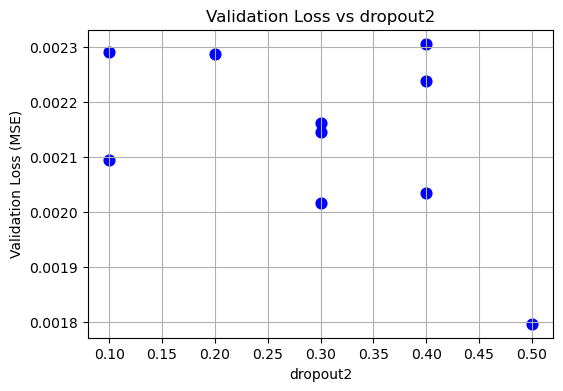

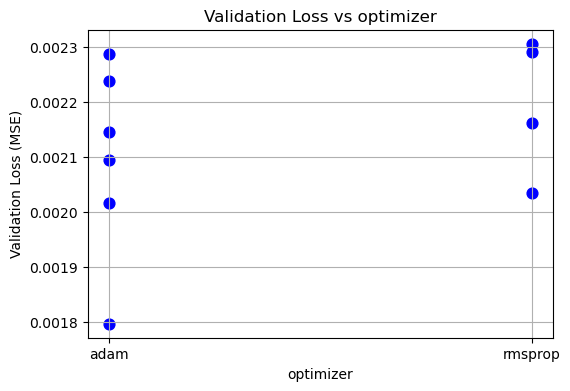

In [8]:
tuner.results_summary()

trials = tuner.oracle.get_best_trials(num_trials=10)
param_names = list(trials[0].hyperparameters.values.keys())
results = {param: [] for param in param_names}
val_losses = []

for trial in trials:
    hp = trial.hyperparameters
    for param in param_names:
        results[param].append(hp.get(param))
    val_losses.append(trial.score)

for param in param_names:
    plt.figure(figsize=(6, 4))
    plt.scatter(results[param], val_losses, c='blue', s=60)
    plt.title(f'Validation Loss vs {param}')
    plt.xlabel(param)
    plt.ylabel('Validation Loss (MSE)')
    plt.grid(True)
    plt.show()

# Evaluate best model on test set  
Generate predictions, inverse transform, and plot performance.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


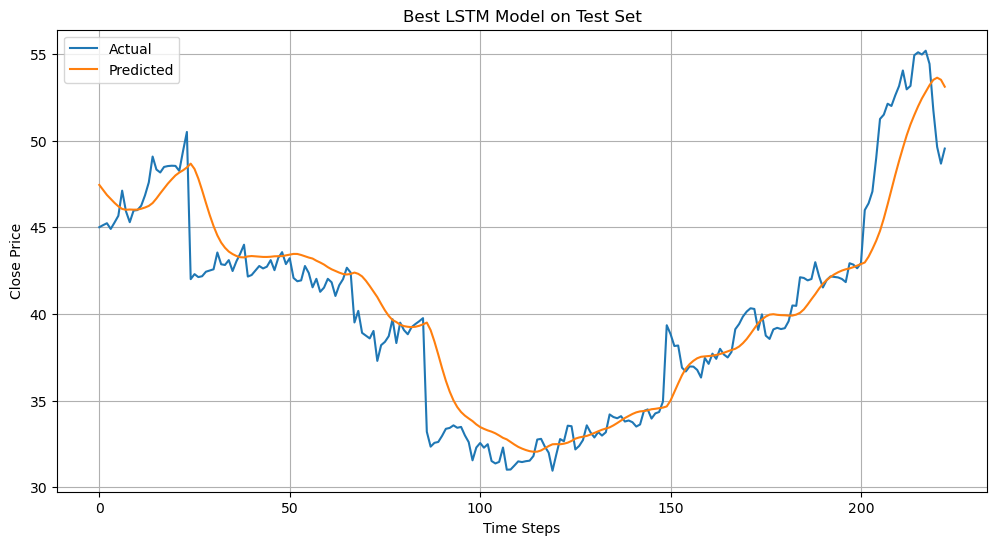

Test RMSE: 2.0840


In [9]:
y_pred_scaled = best_model.predict(X_test)

n_features = scaler.n_features_in_
padding_test = np.zeros((len(y_test), n_features))
padding_pred = np.zeros((len(y_pred_scaled), n_features))
close_idx = list(train_data.columns).index('close')

padding_test[:, close_idx] = y_test
padding_pred[:, close_idx] = y_pred_scaled[:, 0]

y_test_rescaled = scaler.inverse_transform(padding_test)[:, close_idx]
y_pred_rescaled = scaler.inverse_transform(padding_pred)[:, close_idx]

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("Best LSTM Model on Test Set")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled)):.4f}")

# Export first-day-of-month predictions to CSV  
Extract the first prediction of each month and save results to a file.


In [10]:
test_dates = test_data.index[sequence_length:]
results_df = pd.DataFrame({
    "date": test_dates,
    "true_close": y_test_rescaled,
    "predicted_close": y_pred_rescaled
})
results_df['date'] = pd.to_datetime(results_df['date'])
results_df.set_index('date', inplace=True)

first_days = results_df.resample('MS').first().dropna().reset_index()
first_days.insert(0, "stock", stock_name)

filename = f"{stock_name.lower()}_lstm_pred.csv"
first_days.to_csv(filename, index=False)

print(f"✅ Monthly predictions saved to {filename}")
display(first_days)


✅ Monthly predictions saved to stx_lstm_pred.csv


,stock,date,true_close,predicted_close
0,STX,2017-03-01,45.01,47.451958
1,STX,2017-04-01,45.30,46.032465
2,STX,2017-05-01,42.18,47.140784
3,STX,2017-06-01,42.88,43.382011
4,STX,2017-07-01,38.59,41.618266
5,STX,2017-08-01,33.37,36.144664
6,STX,2017-09-01,31.80,32.046300
7,STX,2017-10-01,34.20,33.453067
8,STX,2017-11-01,36.96,37.296708
9,STX,2017-12-01,39.11,39.987906
